## Heart Disease Binary Classification with MLPclassifier and KerasClassifier

The dataset comes with 3 predictors, namely **cholesteral**,**thalac** and **old peak**. All three are quantitative variables that we will use to predict 2 classes, 'positive' and 'negative' for the target variable **disease**.

In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

C:\Users\Ali\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('C:/../heart_disease_for_curves.csv')

In [3]:
df.head()

,sample,cholesteral,thalac,oldpeak,disease
0,train,261,141,3,positive
1,train,263,105,2,negative
2,train,269,121,2,negative
3,train,177,140,4,negative
4,train,256,142,6,positive


The first column determines whether an observation is to be used for the training set or test set (150 data points for training and 120 for test).

**Note**: Both standard and minmax normalization resulted in lower prediction accuracy.

In [14]:
df_train = df[df['sample'] == 'train']
df_test = df[df['sample'] == 'test']

df_train = df_train.drop('sample', axis=1)
df_test = df_test.drop('sample', axis=1)

xtrain = df_train.drop('disease', axis=1)
ytrain = df_train['disease']

xtest = df_test.drop('disease', axis=1)
ytest = df_test['disease']

print(len(xtrain),len(xtest))

150 120


The following multi-layer perceptron classfier model is offered as a benchmark and the aim of this notebook is to try and beat the prediction accuracy.

In [15]:
clf = MLPClassifier(activation = 'relu',hidden_layer_sizes=(100,100,100), max_iter=500, 
                    alpha=0.0001,solver='adam', random_state=21,tol=0.000000001)

In [16]:
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)

In [17]:
accuracy_score(ytest, y_pred)

0.7583333333333333

In [18]:
cm = confusion_matrix(ytest, y_pred)
cm

array([[54, 12],
       [17, 37]], dtype=int64)

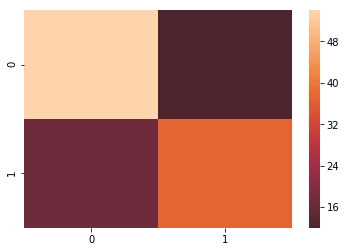

In [19]:
sns.heatmap(cm, center=True)
plt.show()

## GridsearchCV and MLPclassifier

An implementation of the sklearn gridsearchcv on the MLPclassifier in the hopes of finding more optimal parameters using the standard cross validation.

Activation function **relu** and solver **adam** are retained as experimentation showed them to be superior to the alternatives.

The following parameters were involved in the grid search:
* alpha:                L2 regularization
* tol:                  tolerance for optimization
* hidden_layer_sizes:   # of neurons per hidden layer and # of hidden layers
* learning_rate_init:   initial learning rate; controls stepsize for weights update
* random_state:         seed used by the random number generator

In [22]:
%%time
s = [0.0001,0.001,0.01,0.1]

parameters = {'alpha': 10.0 ** -np.arange(1, 5), 'solver' : ['adam'], 'activation' : ['relu'],
              'hidden_layer_sizes':[(10,),(50,),(100,),(10,10),(50,50),(100,100),
                                    (10,10,10),(50,50,50),(100,100,100)], 
              'random_state':np.arange(1,25), 'learning_rate_init' : s, 'tol' : [0.000000001]}
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=3,
                           scoring='accuracy')


clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)

print(clf.score(xtrain, ytrain))
print(clf.best_params_)

0.7133333333333334
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'random_state': 16, 'solver': 'adam', 'tol': 1e-09}
Wall time: 8min 45s


In this version, the stratified cross-validation technique is used.

Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole.

In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels.

Using the best paramaters from above, the model is re-run with stratified cross-validation. The same result is obtained thereby showing that the data representation is fair.

In [29]:
%%time

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

parameters = {'alpha': [0.001], 'solver' : ['adam'], 'activation' : ['relu'], 
              'hidden_layer_sizes':[(10,)], 
              'random_state':[16], 'learning_rate_init' : [0.01], 'tol' : [0.000000001]}
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=kfold,
                           scoring='accuracy')


clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)

print(clf.score(xtrain, ytrain))
print(clf.best_params_)

0.7133333333333334
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'random_state': 16, 'solver': 'adam', 'tol': 1e-09}
Wall time: 28.8 s


## KerasClassifier with GridSearchCV

Yet another attempt in the dark to obtain better results using the KerasClassifier.

In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

As a necessary preprocessing step the labels need to be numerically encoded.

In [4]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(df['disease'])
encoded_Y = encoder.transform(df['disease'])

A baseline model is created with this function which serves as a springboard for the grid search.

In [8]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Two models below are designed to expose the difference in performance with respect to standardization and stratified cross-validation.

This first one is with standardized set and a stratified CV.
It can be seen that the mean cross validation score of **72.96%** does not exceed the benchmark of **75.8%**.
However, even though it's bad practice to report, the maximum accuracy obtained is **85.2%**.

In [19]:
%%time

# evaluate baseline model with standardized dataset and stratified CV
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, df[['cholesteral','thalac','oldpeak']], encoded_Y, cv=kfold)

Epoch 1/100
243/243 [==============================] - 7s 28ms/step - loss: 0.6915 - acc: 0.6790
Epoch 2/100
243/243 [==============================] - 0s 349us/step - loss: 0.6900 - acc: 0.6584
Epoch 3/100
243/243 [==============================] - 0s 413us/step - loss: 0.6882 - acc: 0.6749
Epoch 4/100
243/243 [==============================] - 0s 478us/step - loss: 0.6862 - acc: 0.6790
Epoch 5/100
243/243 [==============================] - 0s 413us/step - loss: 0.6836 - acc: 0.6872
Epoch 6/100
243/243 [==============================] - 0s 413us/step - loss: 0.6804 - acc: 0.6955
Epoch 7/100
243/243 [==============================] - 0s 477us/step - loss: 0.6765 - acc: 0.6955
Epoch 8/100
243/243 [==============================] - 0s 413us/step - loss: 0.6719 - acc: 0.6955
Epoch 9/100
243/243 [==============================] - 0s 477us/step - loss: 0.6670 - acc: 0.7078
Epoch 10/100
243/243 [==============================] - 0s 477us/step - loss: 0.6609 - acc: 0.7119
Epoch 11/100
243/243

243/243 [==============================] - 0s 374us/step - loss: 0.5185 - acc: 0.7449
Epoch 66/100
243/243 [==============================] - 0s 450us/step - loss: 0.5185 - acc: 0.7449
Epoch 67/100
243/243 [==============================] - 0s 413us/step - loss: 0.5183 - acc: 0.7449
Epoch 68/100
243/243 [==============================] - 0s 413us/step - loss: 0.5183 - acc: 0.7449
Epoch 69/100
243/243 [==============================] - 0s 349us/step - loss: 0.5180 - acc: 0.7449
Epoch 70/100
243/243 [==============================] - 0s 349us/step - loss: 0.5179 - acc: 0.7449
Epoch 71/100
243/243 [==============================] - 0s 349us/step - loss: 0.5178 - acc: 0.7449
Epoch 72/100
243/243 [==============================] - 0s 349us/step - loss: 0.5177 - acc: 0.7449
Epoch 73/100
243/243 [==============================] - 0s 349us/step - loss: 0.5176 - acc: 0.7449
Epoch 74/100
243/243 [==============================] - 0s 412us/step - loss: 0.5176 - acc: 0.7449
Epoch 75/100
243/243 [=

243/243 [==============================] - 0s 349us/step - loss: 0.5456 - acc: 0.7407
Epoch 30/100
243/243 [==============================] - 0s 349us/step - loss: 0.5430 - acc: 0.7407
Epoch 31/100
243/243 [==============================] - ETA: 0s - loss: 0.5537 - acc: 0.724 - 0s 349us/step - loss: 0.5406 - acc: 0.7407
Epoch 32/100
243/243 [==============================] - 0s 413us/step - loss: 0.5390 - acc: 0.7366
Epoch 33/100
243/243 [==============================] - 0s 413us/step - loss: 0.5373 - acc: 0.7325
Epoch 34/100
243/243 [==============================] - 0s 411us/step - loss: 0.5358 - acc: 0.7325
Epoch 35/100
243/243 [==============================] - 0s 413us/step - loss: 0.5345 - acc: 0.7366
Epoch 36/100
243/243 [==============================] - 0s 413us/step - loss: 0.5335 - acc: 0.7366
Epoch 37/100
243/243 [==============================] - 0s 413us/step - loss: 0.5323 - acc: 0.7325
Epoch 38/100
243/243 [==============================] - 0s 285us/step - loss: 0.5314

243/243 [==============================] - 0s 386us/step - loss: 0.5120 - acc: 0.7325
Epoch 92/100
243/243 [==============================] - 0s 386us/step - loss: 0.5119 - acc: 0.7325
Epoch 93/100
243/243 [==============================] - 0s 386us/step - loss: 0.5120 - acc: 0.7325
Epoch 94/100
243/243 [==============================] - 0s 349us/step - loss: 0.5116 - acc: 0.7325
Epoch 95/100
243/243 [==============================] - 0s 316us/step - loss: 0.5116 - acc: 0.7325
Epoch 96/100
243/243 [==============================] - 0s 301us/step - loss: 0.5112 - acc: 0.7325
Epoch 97/100
243/243 [==============================] - 0s 349us/step - loss: 0.5111 - acc: 0.7325
Epoch 98/100
243/243 [==============================] - 0s 349us/step - loss: 0.5109 - acc: 0.7325
Epoch 99/100
243/243 [==============================] - 0s 413us/step - loss: 0.5108 - acc: 0.7325
Epoch 100/100
27/27 [==============================] - 3s 102ms/step
Epoch 1/100
243/243 [==============================] 

243/243 [==============================] - 0s 502us/step - loss: 0.5261 - acc: 0.7490
Epoch 55/100
243/243 [==============================] - 0s 426us/step - loss: 0.5258 - acc: 0.7449
Epoch 56/100
243/243 [==============================] - 0s 322us/step - loss: 0.5255 - acc: 0.7449
Epoch 57/100
243/243 [==============================] - 0s 349us/step - loss: 0.5251 - acc: 0.7449
Epoch 58/100
243/243 [==============================] - 0s 349us/step - loss: 0.5249 - acc: 0.7449
Epoch 59/100
243/243 [==============================] - 0s 411us/step - loss: 0.5248 - acc: 0.7490
Epoch 60/100
243/243 [==============================] - 0s 413us/step - loss: 0.5244 - acc: 0.7490
Epoch 61/100
243/243 [==============================] - 0s 349us/step - loss: 0.5243 - acc: 0.7490
Epoch 62/100
243/243 [==============================] - 0s 348us/step - loss: 0.5242 - acc: 0.7490
Epoch 63/100
243/243 [==============================] - 0s 336us/step - loss: 0.5238 - acc: 0.7490
Epoch 64/100
243/243 [=

243/243 [==============================] - ETA: 0s - loss: 0.6186 - acc: 0.765 - 0s 413us/step - loss: 0.6171 - acc: 0.7449
Epoch 19/100
243/243 [==============================] - 0s 348us/step - loss: 0.6087 - acc: 0.7490
Epoch 20/100
243/243 [==============================] - 0s 417us/step - loss: 0.6010 - acc: 0.7449
Epoch 21/100
243/243 [==============================] - 0s 327us/step - loss: 0.5933 - acc: 0.7490
Epoch 22/100
243/243 [==============================] - 0s 322us/step - loss: 0.5862 - acc: 0.7490
Epoch 23/100
243/243 [==============================] - 0s 349us/step - loss: 0.5793 - acc: 0.7490
Epoch 24/100
243/243 [==============================] - 0s 413us/step - loss: 0.5724 - acc: 0.7490
Epoch 25/100
243/243 [==============================] - 0s 413us/step - loss: 0.5670 - acc: 0.7449
Epoch 26/100
243/243 [==============================] - 0s 413us/step - loss: 0.5614 - acc: 0.7449
Epoch 27/100
243/243 [==============================] - 0s 413us/step - loss: 0.5560

243/243 [==============================] - 0s 349us/step - loss: 0.5208 - acc: 0.7366
Epoch 83/100
243/243 [==============================] - 0s 413us/step - loss: 0.5206 - acc: 0.7407
Epoch 84/100
243/243 [==============================] - 0s 322us/step - loss: 0.5205 - acc: 0.7366
Epoch 85/100
243/243 [==============================] - 0s 349us/step - loss: 0.5203 - acc: 0.7366
Epoch 86/100
243/243 [==============================] - 0s 411us/step - loss: 0.5202 - acc: 0.7407
Epoch 87/100
243/243 [==============================] - 0s 426us/step - loss: 0.5201 - acc: 0.7407
Epoch 88/100
243/243 [==============================] - 0s 399us/step - loss: 0.5200 - acc: 0.7407
Epoch 89/100
243/243 [==============================] - 0s 285us/step - loss: 0.5200 - acc: 0.7407
Epoch 90/100
243/243 [==============================] - 0s 413us/step - loss: 0.5199 - acc: 0.7449
Epoch 91/100
243/243 [==============================] - 0s 413us/step - loss: 0.5198 - acc: 0.7449
Epoch 92/100
243/243 [=

In [20]:
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.96% (6.43%)


In [25]:
print("Best: %.2f%% " % (results.max()*100))

Best: 85.19% 


For this second one with no standardization and only stratified CV the mean cross validation score of **74.1%** approaches the benchmark of **75.8%** but it doesn't surpass it. Yet again the maximum attainable accuracy is **85.2%**.

In [22]:
%%time

# evaluate model with stratified CV
estimator = KerasClassifier(build_fn=create_baseline, epochs=100)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results1 = cross_val_score(estimator, df[['cholesteral','thalac','oldpeak']], encoded_Y, cv=kfold)

Epoch 1/100
243/243 [==============================] - 7s 30ms/step - loss: 0.7544 - acc: 0.5556
Epoch 2/100
243/243 [==============================] - 0s 349us/step - loss: 0.7096 - acc: 0.4239
Epoch 3/100
243/243 [==============================] - 0s 349us/step - loss: 0.7008 - acc: 0.4444
Epoch 4/100
243/243 [==============================] - 0s 349us/step - loss: 0.6850 - acc: 0.5556
Epoch 5/100
243/243 [==============================] - 0s 413us/step - loss: 0.6847 - acc: 0.5556
Epoch 6/100
243/243 [==============================] - 0s 478us/step - loss: 0.6760 - acc: 0.5556
Epoch 7/100
243/243 [==============================] - 0s 349us/step - loss: 0.6693 - acc: 0.5597
Epoch 8/100
243/243 [==============================] - 0s 386us/step - loss: 0.6629 - acc: 0.6091
Epoch 9/100
243/243 [==============================] - 0s 349us/step - loss: 0.6570 - acc: 0.6379
Epoch 10/100
243/243 [==============================] - 0s 413us/step - loss: 0.6525 - acc: 0.6255
Epoch 11/100
243/243

243/243 [==============================] - 0s 413us/step - loss: 0.5289 - acc: 0.7449
Epoch 66/100
243/243 [==============================] - 0s 413us/step - loss: 0.5261 - acc: 0.7366
Epoch 67/100
243/243 [==============================] - 0s 477us/step - loss: 0.5252 - acc: 0.7407
Epoch 68/100
243/243 [==============================] - 0s 413us/step - loss: 0.5271 - acc: 0.7407
Epoch 69/100
243/243 [==============================] - 0s 478us/step - loss: 0.5262 - acc: 0.7449
Epoch 70/100
243/243 [==============================] - 0s 413us/step - loss: 0.5264 - acc: 0.7407
Epoch 71/100
243/243 [==============================] - 0s 349us/step - loss: 0.5252 - acc: 0.7449
Epoch 72/100
243/243 [==============================] - 0s 358us/step - loss: 0.5260 - acc: 0.7449
Epoch 73/100
243/243 [==============================] - 0s 339us/step - loss: 0.5246 - acc: 0.7407
Epoch 74/100
243/243 [==============================] - 0s 413us/step - loss: 0.5289 - acc: 0.7407
Epoch 75/100
243/243 [=

243/243 [==============================] - 0s 360us/step - loss: 0.5522 - acc: 0.7284
Epoch 30/100
243/243 [==============================] - 0s 337us/step - loss: 0.5489 - acc: 0.7407
Epoch 31/100
243/243 [==============================] - 0s 420us/step - loss: 0.5495 - acc: 0.7366
Epoch 32/100
243/243 [==============================] - 0s 343us/step - loss: 0.5504 - acc: 0.7325
Epoch 33/100
243/243 [==============================] - 0s 413us/step - loss: 0.5491 - acc: 0.7284
Epoch 34/100
243/243 [==============================] - 0s 349us/step - loss: 0.5472 - acc: 0.7325
Epoch 35/100
243/243 [==============================] - 0s 349us/step - loss: 0.5477 - acc: 0.7325
Epoch 36/100
243/243 [==============================] - 0s 477us/step - loss: 0.5472 - acc: 0.7407
Epoch 37/100
243/243 [==============================] - 0s 349us/step - loss: 0.5461 - acc: 0.7284
Epoch 38/100
243/243 [==============================] - 0s 349us/step - loss: 0.5443 - acc: 0.7407
Epoch 39/100
243/243 [=

243/243 [==============================] - 0s 412us/step - loss: 0.5386 - acc: 0.7407
Epoch 94/100
243/243 [==============================] - 0s 413us/step - loss: 0.5386 - acc: 0.7531
Epoch 95/100
243/243 [==============================] - 0s 413us/step - loss: 0.5392 - acc: 0.7449
Epoch 96/100
243/243 [==============================] - 0s 349us/step - loss: 0.5413 - acc: 0.7325
Epoch 97/100
243/243 [==============================] - 0s 413us/step - loss: 0.5378 - acc: 0.7449
Epoch 98/100
243/243 [==============================] - 0s 386us/step - loss: 0.5406 - acc: 0.7449
Epoch 99/100
243/243 [==============================] - ETA: 0s - loss: 0.5593 - acc: 0.739 - 0s 322us/step - loss: 0.5379 - acc: 0.7572
Epoch 100/100
27/27 [==============================] - 3s 124ms/step
Epoch 1/100
243/243 [==============================] - 8s 33ms/step - loss: 0.7295 - acc: 0.5556
Epoch 2/100
243/243 [==============================] - 0s 349us/step - loss: 0.6914 - acc: 0.5556
Epoch 3/100
243/24

243/243 [==============================] - 0s 349us/step - loss: 0.5667 - acc: 0.7243
Epoch 76/100
243/243 [==============================] - 0s 413us/step - loss: 0.5615 - acc: 0.7243
Epoch 77/100
243/243 [==============================] - 0s 413us/step - loss: 0.5614 - acc: 0.7160
Epoch 78/100
243/243 [==============================] - 0s 413us/step - loss: 0.5593 - acc: 0.7202
Epoch 79/100
243/243 [==============================] - 0s 413us/step - loss: 0.5650 - acc: 0.7366
Epoch 80/100
243/243 [==============================] - 0s 349us/step - loss: 0.5616 - acc: 0.7202
Epoch 81/100
243/243 [==============================] - 0s 349us/step - loss: 0.5651 - acc: 0.7160
Epoch 82/100
243/243 [==============================] - 0s 411us/step - loss: 0.5596 - acc: 0.7119
Epoch 83/100
243/243 [==============================] - 0s 413us/step - loss: 0.5618 - acc: 0.7202
Epoch 84/100
243/243 [==============================] - 0s 349us/step - loss: 0.5605 - acc: 0.7160
Epoch 85/100
243/243 [=

243/243 [==============================] - 0s 413us/step - loss: 0.5577 - acc: 0.7160
Epoch 40/100
243/243 [==============================] - 0s 349us/step - loss: 0.5562 - acc: 0.7202
Epoch 41/100
243/243 [==============================] - 0s 412us/step - loss: 0.5610 - acc: 0.7160
Epoch 42/100
243/243 [==============================] - 0s 411us/step - loss: 0.5572 - acc: 0.7202
Epoch 43/100
243/243 [==============================] - 0s 413us/step - loss: 0.5663 - acc: 0.7160
Epoch 44/100
243/243 [==============================] - 0s 348us/step - loss: 0.5508 - acc: 0.7243
Epoch 45/100
243/243 [==============================] - 0s 386us/step - loss: 0.5609 - acc: 0.7325
Epoch 46/100
243/243 [==============================] - 0s 349us/step - loss: 0.5579 - acc: 0.7119
Epoch 47/100
243/243 [==============================] - 0s 349us/step - loss: 0.5556 - acc: 0.7160
Epoch 48/100
243/243 [==============================] - 0s 413us/step - loss: 0.5571 - acc: 0.7325
Epoch 49/100
243/243 [=

Epoch 3/100
243/243 [==============================] - 0s 403us/step - loss: 0.7352 - acc: 0.4074
Epoch 4/100
243/243 [==============================] - 0s 413us/step - loss: 0.7105 - acc: 0.4979
Epoch 5/100
243/243 [==============================] - 0s 413us/step - loss: 0.7025 - acc: 0.5556
Epoch 6/100
243/243 [==============================] - 0s 349us/step - loss: 0.6952 - acc: 0.5556
Epoch 7/100
243/243 [==============================] - 0s 349us/step - loss: 0.6844 - acc: 0.5556
Epoch 8/100
243/243 [==============================] - 0s 413us/step - loss: 0.6753 - acc: 0.5638
Epoch 9/100
243/243 [==============================] - 0s 349us/step - loss: 0.6645 - acc: 0.5761
Epoch 10/100
243/243 [==============================] - 0s 413us/step - loss: 0.6586 - acc: 0.6173
Epoch 11/100
243/243 [==============================] - 0s 349us/step - loss: 0.6533 - acc: 0.6626
Epoch 12/100
243/243 [==============================] - 0s 413us/step - loss: 0.6496 - acc: 0.6872
Epoch 13/100
243/

In [26]:
print("Results: %.2f%% (%.2f%%)" % (results1.mean()*100, results1.std()*100))

Results: 74.07% (7.41%)


In [27]:
print("Best: %.2f%% " % (results1.max()*100))

Best: 85.19% 


Below is the code for a thorough grid search of all relevant parameters. There are no results associated with this cell since it takes very long for it to complete. I ran it for 8 hours and got nothing. I can only speculate but I believe it will ultimately give better predictions than the benchmark.

In [ ]:
%%time

# create model
model = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'Adam']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
init_mode = ['uniform', 'normal']
activation = ['relu', 'sigmoid']
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [1, 5, 10, 15, 20, 25, 30]

param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs, learn_rate=learn_rate,
                  momentum=momentum, init_mode=init_mode, activation=activation,
                  weight_constraint=weight_constraint, dropout_rate=dropout_rate, neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(df[['cholesteral','thalac','oldpeak']], encoded_Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))